[   0   10   20   30   40   50   60   70   80   90  100  110  120  130
  140  150  160  170  180  190  200  210  220  230  240  250  260  270
  280  290  300  310  320  330  340  350  360  370  380  390  400  410
  420  430  440  450  460  470  480  490  500  510  520  530  540  550
  560  570  580  590  600  610  620  630  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110
 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250
 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390
 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530
 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670
 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810
 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950
 1960 

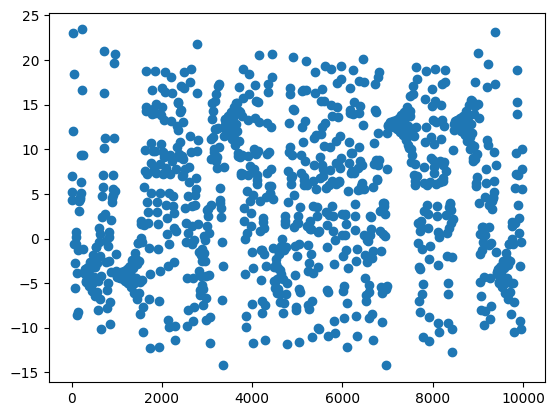

None


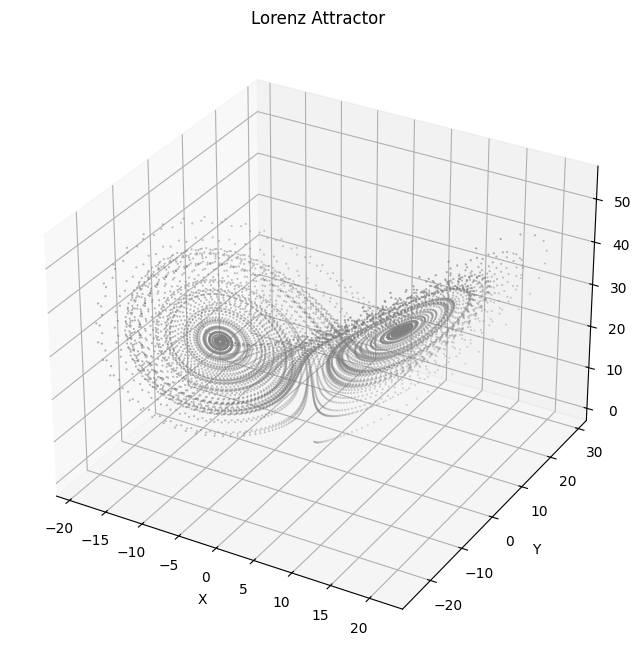

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from scipy.linalg import fractional_matrix_power

rng = np.random.default_rng()

def lorenz(xyz, *, s=10, r=28, b=2.667):
   """
   Parameters
   ----------
   xyz : array-like, shape (3,)
      Point of interest in three-dimensional space.
   s, r, b : float
      Parameters defining the Lorenz attractor.

   Returns
   -------
   xyz_dot : array, shape (3,)
      Values of the Lorenz attractor's partial derivatives at *xyz*.
   """
   x, y, z = xyz
   x_dot = s*(y - x)
   y_dot = r*x - y - x*z
   z_dot = x*y - b*z
   return np.array([x_dot, y_dot, z_dot])

dt = 0.01
N = 10_000

delta_t = 10

t_dis = np.arange(0,N,delta_t)

R_o = 10 * np.array([[1]])
H = np.array([[1,0,0]])

Y = np.zeros((1,N // delta_t)) #Observation is x_k 

xyzs = np.empty((N, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
y_index = 0
for i in range(N-1):
   xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

   if(i % delta_t == 0): 
    Y[:,y_index] = H @ xyzs[i]
    y_index += 1

Y += rng.multivariate_normal([0],R_o,len(Y)).T

print(t_dis)
plt.scatter(t_dis,Y[0,:])
plt.show()

# Plot
ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')

ax.scatter(*xyzs.T, s=0.2,color = 'grey')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz Attractor")

print(ax.view_init())


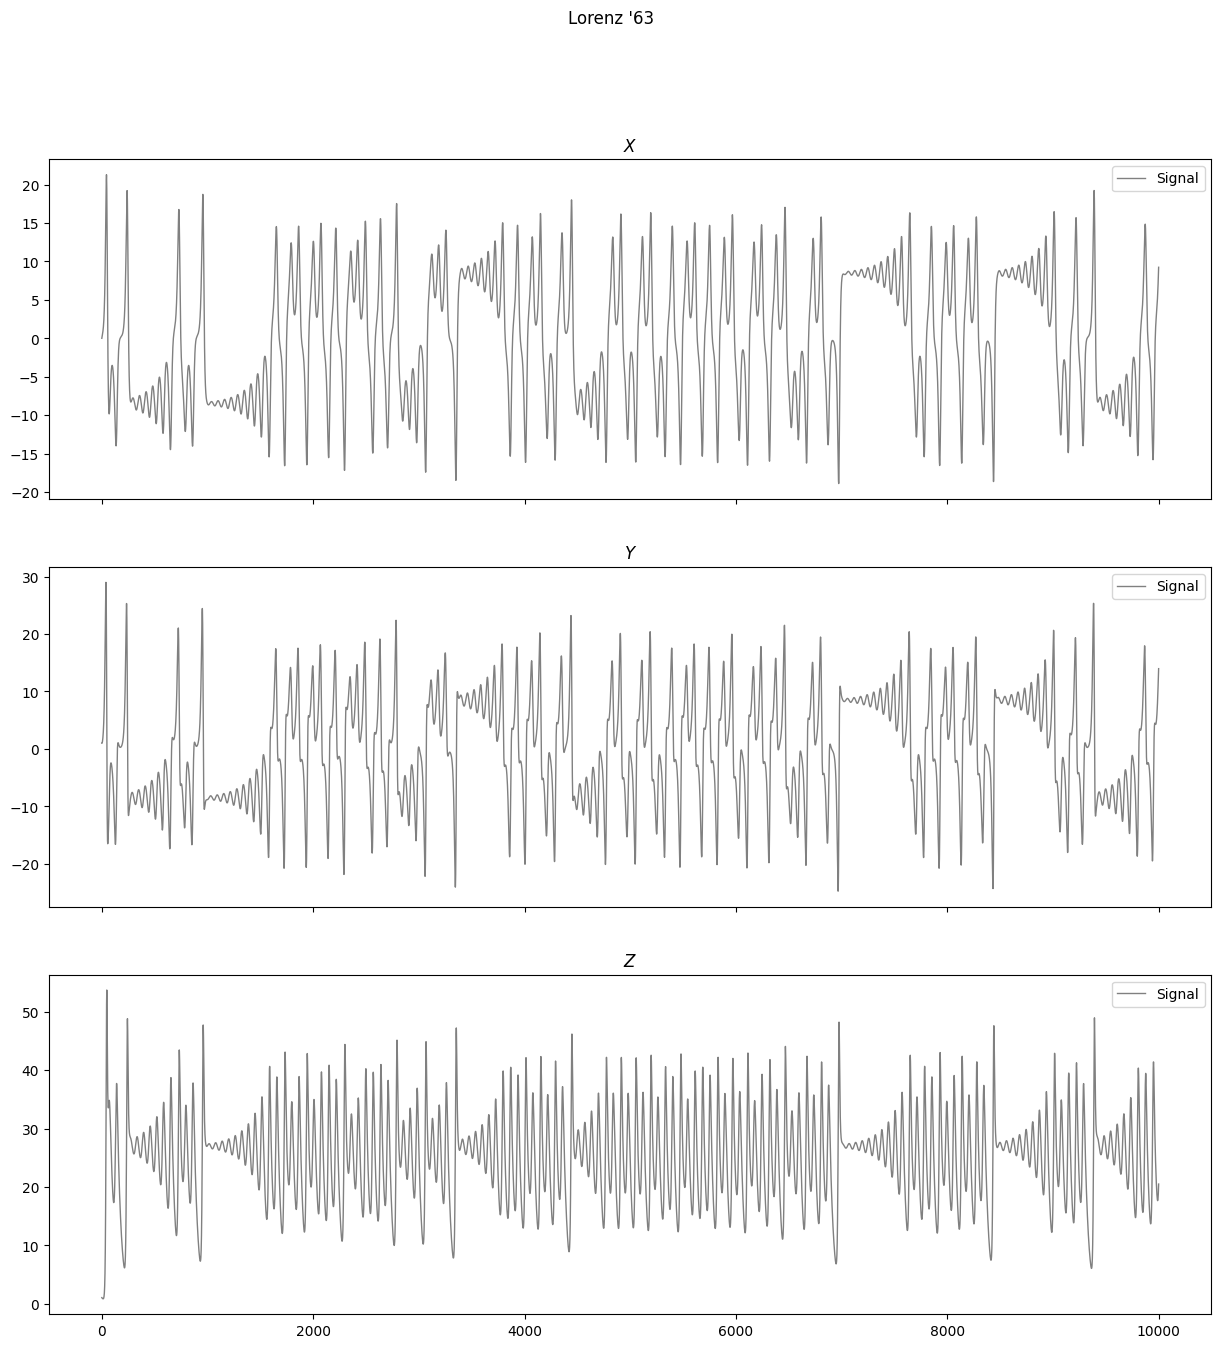

In [2]:
# Plot the true signal, observations, and the Kalman filter estimate.
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Lorenz '63")
axs[0].plot(xyzs[:, 0], color='grey', linewidth=1)
axs[0].legend(['Signal'])
axs[0].set_title("$X$")
axs[1].plot(xyzs[:, 1], color='grey', linewidth=1)
axs[1].legend(['Signal'])
axs[1].set_title("$Y$")

axs[2].plot(xyzs[:, 2], color='grey', linewidth=1)
axs[2].legend(['Signal'])
axs[2].set_title("$Z$")
plt.show()

In [11]:
'''Lin Domain Particle Filter'''
num_particles = 100

x0 = np.array([0., 1., 1.05])  # Initial state (equilibrium)

proc_noise = 0. * np.eye(3)

particle_states = np.zeros((num_particles,3)) # particle array
particle_obs = np.zeros(num_particles)

m_post = np.zeros((3, len(t_dis))) # posterior means

weights = np.ones(num_particles) #weights associated with each particle

'''Setup each particle with an initial state as generated from the prior'''

particle_states = rng.multivariate_normal(x0,np.eye(3),num_particles).T
particle_obs = H @ particle_states


'''Set the weights for each particle in the initial swarm and normalize'''
weights = np.ones(num_particles)
for index in range(np.shape(particle_states)[1]):
    for obv in range(Y.shape[0]):
        weights[index] *= norm.pdf(Y[obv,0],loc=particle_obs[obv,index],scale = 10).squeeze()
        

weights /= np.sum(weights)

cdf = np.cumsum(weights)
    
'''Resample the weights'''

i = 0
resampling_indices = np.zeros(num_particles).astype(int)
u = rng.uniform(0,1/num_particles)
for j in range(0,num_particles): 
    r = u + 1/num_particles * j
    while r > cdf[i]: 
        i += 1
    resampling_indices[j] = i

particle_states_copy = np.copy(particle_states)

particle_states = particle_states_copy[:,resampling_indices]

m_post[:,0] = np.average(particle_states,axis = 1,weights = weights)

# The particle filter is run for the rest of the time steps.
for i_time in range(0, len(t_dis)-1):
    
    print(f"Iteration: {i_time}")

    #simulation
    for index in range(np.shape(particle_states)[1]):
        for _ in range(delta_t):
            particle_states[:,index] = particle_states[:, index] + lorenz(particle_states[:, index]) * dt #+ rng.multivariate_normal(np.zeros(3),proc_noise)

    particle_obs = H @ particle_states + rng.multivariate_normal([0],R_o)

    '''Set the weights for each particle in the swarm and normalize'''
    weights = np.ones(num_particles)

    for index in range(np.shape(particle_states)[1]):
        for obv in range(Y.shape[0]):
            weights[index] *= norm.pdf(Y[obv,i_time],loc=particle_obs[obv,index],scale = 10).squeeze()
    weights /= np.sum(weights)

    '''Resample in lin domain'''
    cdf = np.cumsum(weights)
    
    i = 0
    resampling_indices = np.zeros(num_particles)
    u = rng.uniform(0,1/num_particles)
    for j in range(0,num_particles): 
        r = (u + 1/num_particles * j)
        while r > cdf[i]: 
            i += 1
        resampling_indices[j] = i

    resampling_indices=resampling_indices.astype(int)

    particle_states_copy = np.copy(particle_states)
    particle_states = particle_states_copy[:,resampling_indices]

    m_post[:,i_time+1] = np.average(particle_states,axis=1,weights = weights)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

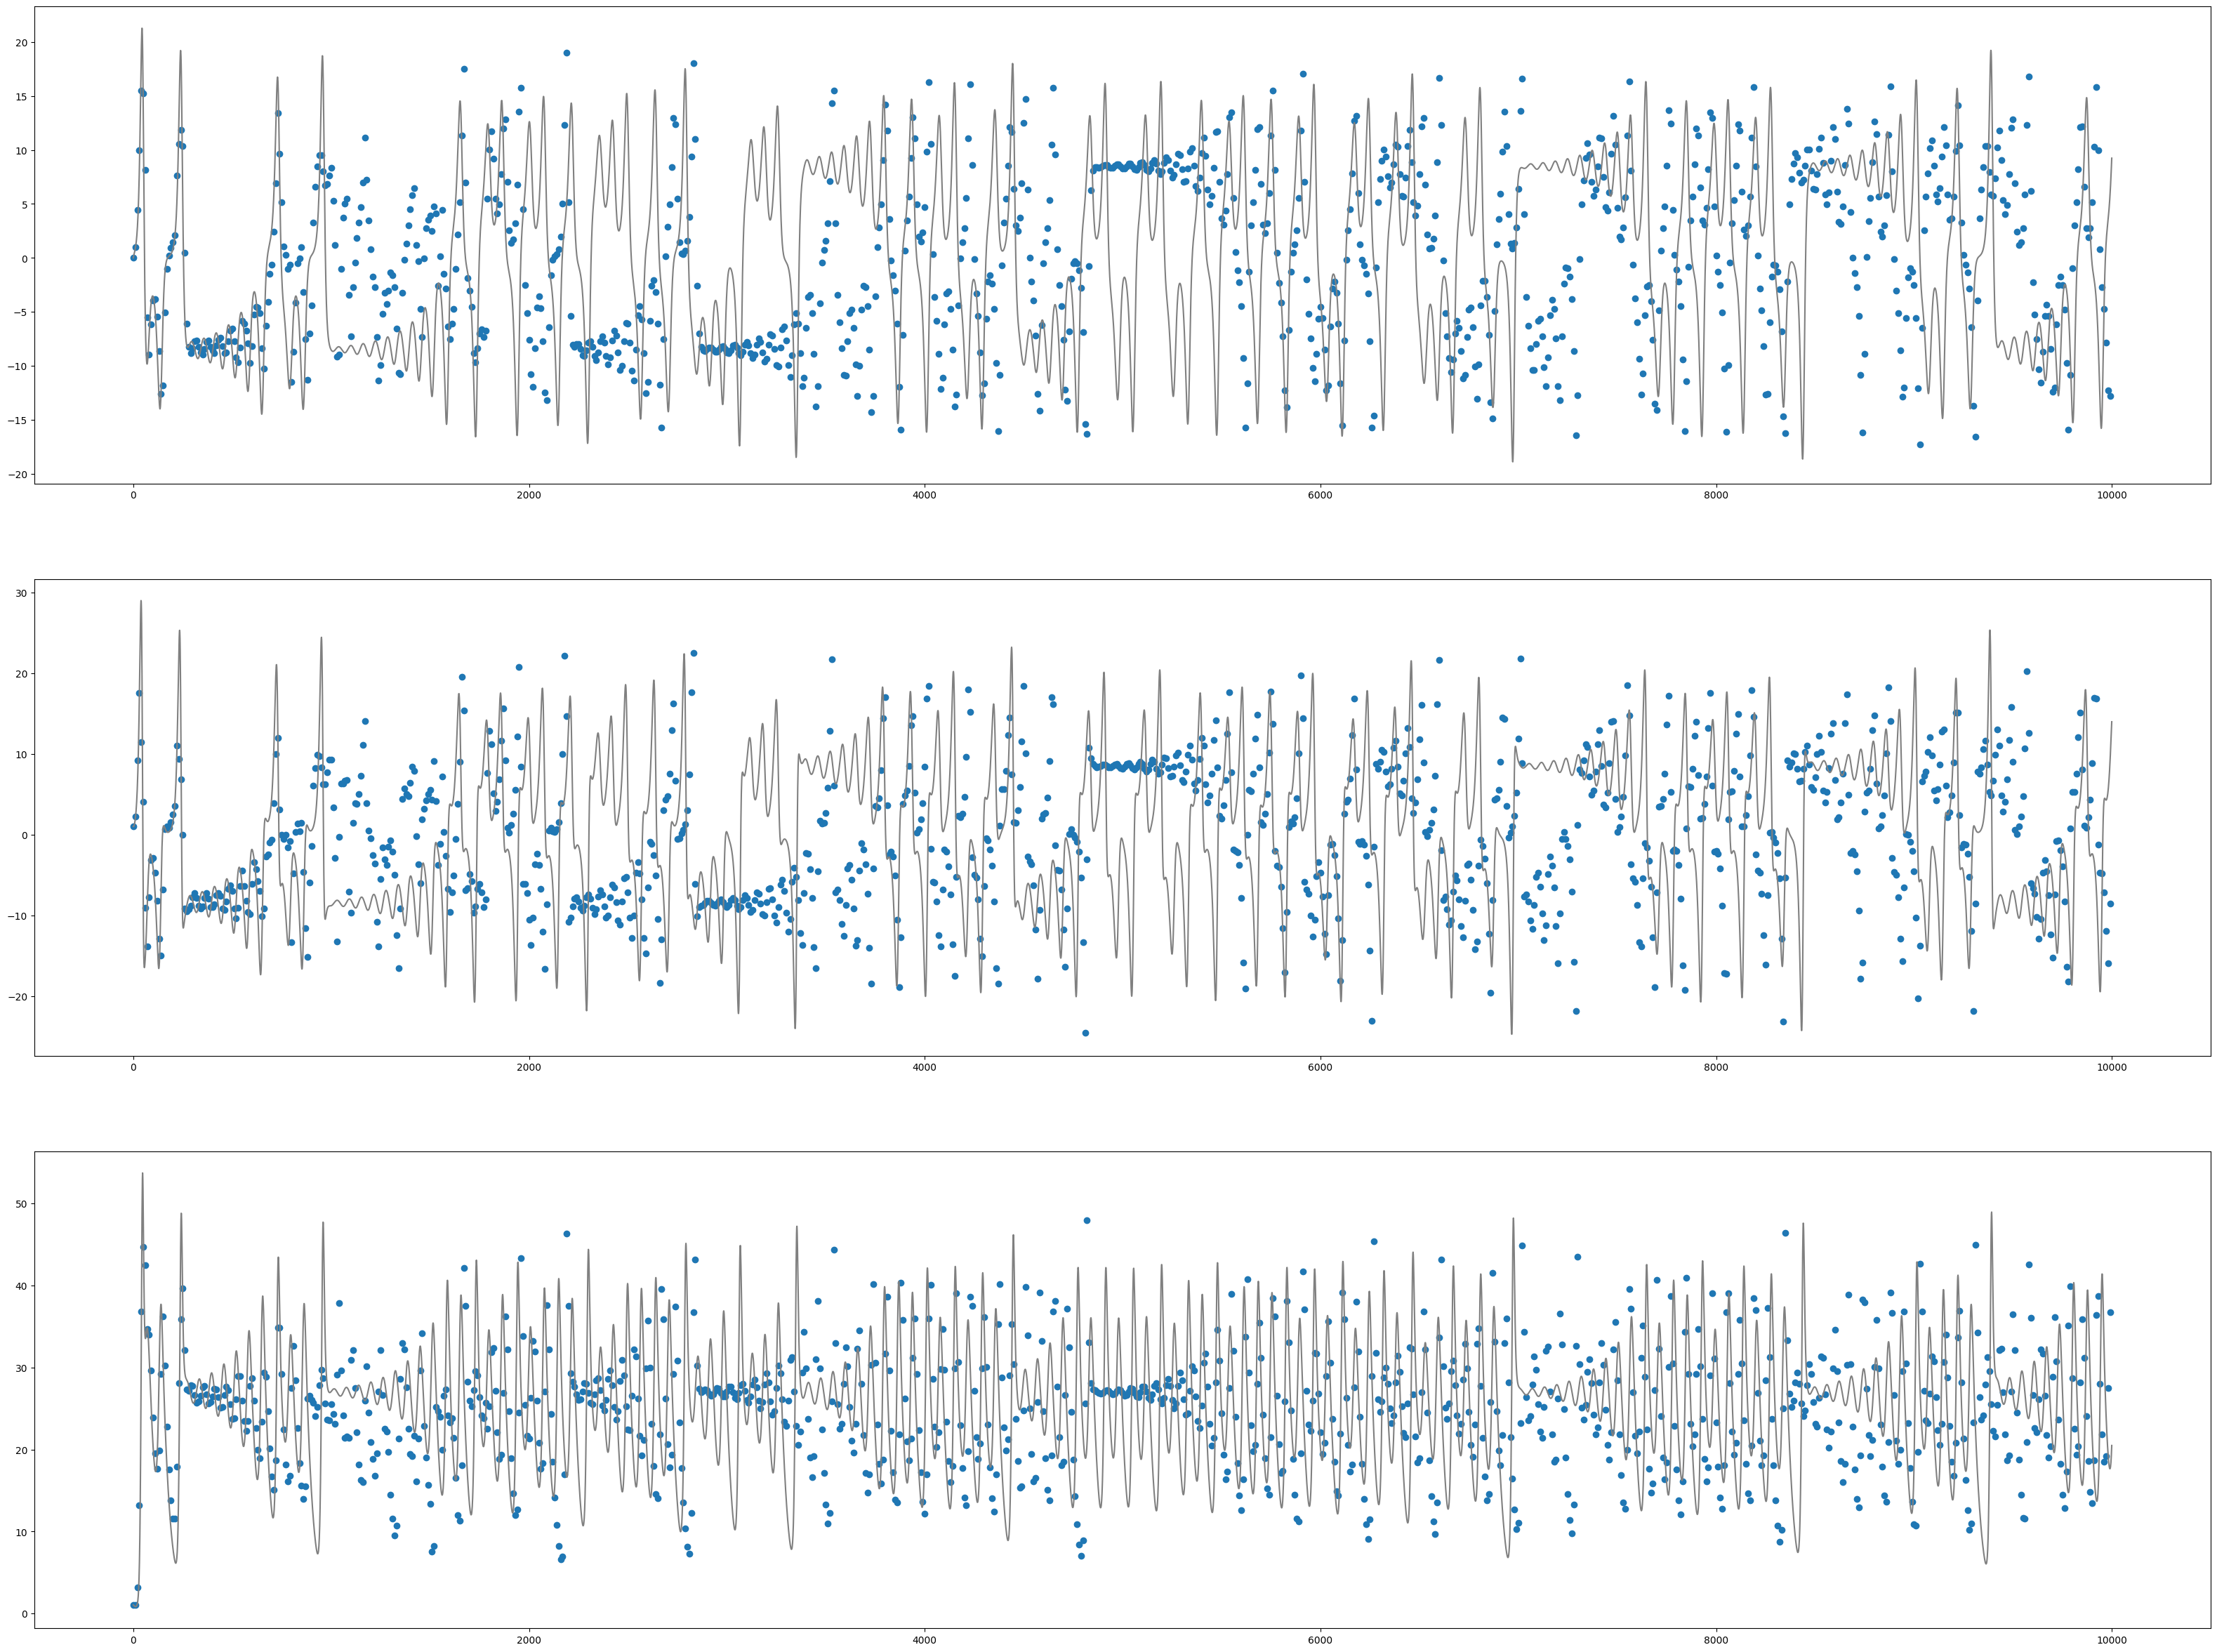

In [12]:
# # Plot the first three variables
# # The true signal is plotted in red
# # The ensemble Kalman filter estimate is plotted in blue
# fig = plt.figure(figsize=(30,15))

# rows = 1
# cols = 1

# axes = fig.subplots(rows, cols)

# axes.plot(xyzs[:, 0],color = 'green',label = 'True Signal')
# #axes.scatter(t_dis,Y.squeeze(),color = 'blue',label = 'Observations')
# axes.scatter(t_dis,m_post[0,:],color = 'red',label = 'Ensemble Mean')
# axes.legend()

# Plot the first three variables
# The true signal is plotted in red
# The ensemble Kalman filter estimate is plotted in blue
fig = plt.figure(figsize=(40,30))

rows = 3
cols = 1

axes = fig.subplots(rows, cols)

axes[0].plot(xyzs[:,0],color='grey')
axes[0].scatter(t_dis,m_post[0,:])

axes[1].plot(xyzs[:,1],color='grey')
axes[1].scatter(t_dis,m_post[1,:])

axes[2].plot(xyzs[:,2],color='grey')
axes[2].scatter(t_dis,m_post[2,:])